### Deep MF

DeepMF 는 Collaborative Filter의 Model-based CF 방식중 Matrix Factorization 문제에 대한 해를 찾기 위한 방법 중 많이 사용하는 SVD(Singular Value Decomposition)방법의 데이터 희소(Sparse)성 때문에 유저 및 아이템의 수가 굉장히 많은 경우는 메모리 문제가 생긴다는 단점을 해결하기 위하여 Embedding 방식의 차원 축소로 해결한 방식 입니다.

**Collaborative Filter**
* Memory-based CF: User-based CF, Item-based CF
* Model-based CF: SVD, DeepMF

![DeepMF](https://d3ansictanv2wj.cloudfront.net/mf_dmf_comparison-a4a7b8e2e3d075dc9c57897d9058ef52.png)


Using TensorFlow backend.


df_data.shape=(100000, 4)
user_id       object
item_id       object
rating       float64
timestamp     object
dtype: object
  user_id item_id  rating  timestamp
0     196     242     3.0  881250949
1     186     302     3.0  891717742
2      22     377     1.0  878887116
3     244      51     2.0  880606923
4     166     346     1.0  886397596
       user_id item_id         rating  timestamp
count   100000  100000  100000.000000     100000
unique     943    1682            NaN      49282
top        405      50            NaN  891033606
freq       737     583            NaN         12
mean       NaN     NaN       3.529860        NaN
std        NaN     NaN       1.125674        NaN
min        NaN     NaN       1.000000        NaN
25%        NaN     NaN       3.000000        NaN
50%        NaN     NaN       4.000000        NaN
75%        NaN     NaN       4.000000        NaN
max        NaN     NaN       5.000000        NaN
np_data_xs.shape=(100000, 2)
np_data_ys.shape=(100000,)
n_users=94

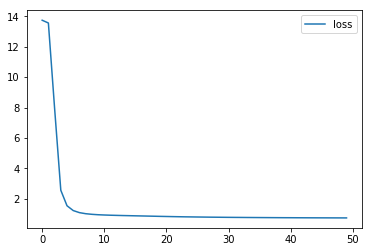

Test RMSE=0.9425726584024547


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os, math, random
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing, model_selection, metrics, dummy
import surprise as sp
from keras import models, layers, optimizers, utils

seed = 0
random.seed(seed)
np.random.seed(seed)

# 데이터
sp_data = sp.Dataset.load_builtin('ml-100k')
df_data = pd.DataFrame(sp_data.raw_ratings, columns=["user_id", "item_id", "rating", "timestamp"])
print("df_data.shape={}".format(df_data.shape))
print(df_data.dtypes)
print(df_data.head())
print(df_data.describe(include='all'))

# user_id = df_data.user_id.astype('category').cat.codes.values
# item_id = df_data.item_id.astype('category').cat.codes.values
# print(user_id.shape)

np_data_xs = df_data[["user_id", "item_id"]].astype('category').values
np_data_ys = df_data["rating"].values
print("np_data_xs.shape={}".format(np_data_xs.shape))
print("np_data_ys.shape={}".format(np_data_ys.shape))

n_users = len(np.unique(np_data_xs[:, 0]))
n_items = len(np.unique(np_data_xs[:, 1]))
n_factors = 3
print("n_users={}, n_items={}, n_factors={}".format(n_users, n_items, n_factors))

np_train_xs, np_test_xs, np_train_ys, np_test_ys = model_selection.train_test_split(
    np_data_xs, np_data_ys, 
    test_size=0.3, shuffle=True, random_state=2)
print("train shape: np_train_xs={}, np_train_ys={}".format(np_train_xs.shape, np_train_ys.shape))
print("test shape: np_test_xs={}, np_test_ys={}".format(np_test_xs.shape, np_test_ys.shape))

np_train_x_user_ids = np_train_xs[:, 0].reshape(-1)
np_train_x_item_ids = np_train_xs[:, 1].reshape(-1)
print("np_train_x_user_ids.shape={}".format(np_train_x_user_ids.shape))
print("np_train_x_item_ids.shape={}".format(np_train_x_item_ids.shape))

np_test_x_user_ids = np_test_xs[:, 0].reshape(-1)
np_test_x_item_ids = np_test_xs[:, 1].reshape(-1)
print("np_train_x_user_ids.shape={}".format(np_test_x_user_ids.shape))
print("np_train_x_item_ids.shape={}".format(np_test_x_item_ids.shape))

# 모델
class DeepMF(models.Model):
    def __init__(self, n_users, n_items, n_factors):
        # multi input/output 을 위해서는 name 지정이 필요
        user_input = layers.Input(shape=[1], name='user_input')
        user_embed = layers.Embedding(n_users+1, n_factors, name='user_embed')(user_input)
        user_vec = layers.Flatten(name='user_vec')(user_embed)
        
        item_input = layers.Input(shape=[1], name='item_input')
        item_embed = layers.Embedding(n_items+1, n_factors, name='item_embed')(item_input)
        item_vec = layers.Flatten(name='item_vec')(item_embed)
        
        dot_vec = layers.dot([user_vec, item_vec], axes=1, name='dot_vec')
        
        super().__init__(inputs=[user_input, item_input], outputs=[dot_vec])
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse', 'mae'])


models = [
    dummy.DummyRegressor(strategy='mean'),  
    DeepMF(n_users = n_users, n_items = n_items, n_factors=3)    
]

for model in models:
    # 학습
    print("\nmodel")
    model_type = str(type(model))
    if model_type.find("DummyRegressor") > -1:
        model.fit(np_train_xs, np_train_ys)
        # 평가
        np_pred_ys = model.predict(np_test_xs)        
    else:
        model.summary()

        history = model.fit([np_train_x_user_ids, np_train_x_item_ids], np_train_ys, epochs=50, verbose=0)
        plt.plot(history.history['loss'], label='loss')
        plt.legend()
        plt.show()    

        # 평가
        np_pred_ys = model.predict([np_test_x_user_ids, np_test_x_item_ids])

    rmse = math.sqrt(metrics.mean_squared_error(np_test_ys, np_pred_ys))
    print("Test RMSE={}".format(rmse))        